In [448]:
import pandas as pd
import os, sys, pickle
import ujson, re, itertools
import numpy as np
import seaborn as sns

from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from gensim.models import Word2Vec
from src.DataReader import DataReader
from src.constants import SPLIT_TIME, STORE_LOCATION, DATA_ROOT, POSTS_FILE, VOTES_FILE
from operator import itemgetter

In [3]:
%matplotlib inline

In [255]:
emb_root = '/Users/prmathur/Documents/Pers/MMDS/Course/CS224W/Project/snap-master/examples/node2vec/emb/'

In [256]:
ut_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, 'ut_p1-q1.emb'), binary=False)

uu_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, 'uu_p0.25-q0.25.emb'), binary=False)

In [257]:
indx2tag_dict = {}
tag2index_dict = {}
with open(os.path.join(STORE_LOCATION, 'graphs/user-tag_keys.txt')) as tg_fl:
    for row in tg_fl:
        k, v = row.strip().split(',')
        indx2tag_dict[float(v.strip())] = k
        tag2index_dict[k] = float(v.strip())

In [209]:
ut_comm = pd.read_csv(os.path.join(STORE_LOCATION, 'community_detection', 'user-tag-new-communityId.tsv'), '\t')

In [210]:
uu_comm = pd.read_csv(os.path.join(STORE_LOCATION, 'community_detection', 'user-user-new-communityId.tsv'), '\t')

In [211]:
def get_ut_comm(nid):
    comm = ut_comm[ut_comm.id==nid]['modularity_class'].values
    ret_vec = np.zeros(8)
    
    if comm.shape[0] > 0:
        ret_vec[comm[0]] = 1
        
    return ret_vec

In [212]:
uu_comm_cnts = uu_comm.groupby('modularity_class').count() > 2

In [213]:
big_comm = uu_comm_cnts[uu_comm_cnts.id==True].index.tolist()

In [214]:
uu_comm['modularity_class'][~uu_comm.modularity_class.isin(big_comm)] = -1

In [215]:
replace_dict = {'modularity_class': 
                dict(zip(uu_comm.modularity_class.unique(), 
                         np.arange(uu_comm.modularity_class.unique().shape[0]) + 10000))}

In [218]:
replace_dict['modularity_class'][-1] = -100

In [219]:
uu_comm = uu_comm.replace(replace_dict)

In [220]:
def get_uu_comm(nid):
    comm = uu_comm[uu_comm.id==nid]['modularity_class'].values
    ret_vec = np.zeros(58)
    
    if comm.shape[0] > 0 and comm[0] >= 10000:
        ret_vec[comm[0] - 10000] = 1
        
    return ret_vec

In [226]:
# get_uu_comm(80)

In [71]:
data_directory = DATA_ROOT

In [262]:
train_df = pd.read_csv(os.path.join(STORE_LOCATION, 'train.csv'))

In [263]:
test_df = pd.read_csv(os.path.join(STORE_LOCATION, 'test.csv'))

In [74]:
post_reader = DataReader(os.path.join(data_directory, POSTS_FILE), True)
post_reader.read_data()

Reading file...
Converting...
Progress | ██████████ | 100% || Estimated time remaining: 0.0 seconds
Conversion complete...
Forming data frame...


In [264]:
pdf = post_reader._df

q_tags_df = pdf[pdf.PostTypeId==1][['Id', 'Tags', 'Title', 'Body', 'FavoriteCount']]

train_df = train_df.merge(q_tags_df, how='left', left_on='QuestionId', right_on='Id', suffixes=('_tr', '_qt'))

test_df = test_df.merge(q_tags_df, how='left', left_on='QuestionId', right_on='Id', suffixes=('_tr', '_qt'))

In [265]:
train_df.FavoriteCount = train_df.FavoriteCount.fillna(0)
test_df.FavoriteCount = test_df.FavoriteCount.fillna(0)

In [266]:
def get_text_rep(train_df, test_df, field):
    vectorizer = TfidfVectorizer(min_df = 2)
    svd = TruncatedSVD(n_components=50)
    
    train_tfidf = vectorizer.fit_transform(train_df[field].values)
    train_tfidf_best = svd.fit_transform(train_tfidf)

    test_tfidf = vectorizer.transform(test_df[field].values)
    test_tfidf_best = svd.transform(test_tfidf)

    return train_tfidf_best, test_tfidf_best

In [267]:
train_body, test_body = get_text_rep(train_df, test_df, 'Body')

In [268]:
train_title, test_title = get_text_rep(train_df, test_df, 'Title')

In [269]:
train_df['body_repr'] = train_body.tolist()
test_df['body_repr'] = test_body.tolist()

In [270]:
train_df['title_repr'] = train_title.tolist()
test_df['title_repr'] = test_title.tolist()

In [271]:
train_df.FavoriteCount = train_df.FavoriteCount.astype(int)
test_df.FavoriteCount = test_df.FavoriteCount.astype(int)

In [272]:
train_df.head()

,QuestionId,AcceptedAnswerUserId,AnswerCreationDate,UsersSorted,UsersJaccard,Id,Tags,Title,Body,FavoriteCount,body_repr,title_repr
0,5.0,45.0,2010-07-20 19:21:52.240,"[45.0, 1102.0, 48.0, 226.0, 242.0]","{48.0: 0.5714285714285714, 242.0: 0.0135135135...",5,"[elementary-number-theory, proof-writing, radi...",How can you prove that the square root of two ...,<p>I have read a few proofs that $\sqrt{2}$ is...,14,"[0.181873417598, 0.0157669000232, 0.0067303937...","[0.324548236195, -0.188566395835, 0.1317537457..."
1,1.0,8.0,2010-07-20 19:22:20.193,"[8.0, 49.0, 25.0, 35.0, 39.0]","{8.0: 0.042253521126760563, 49.0: 0.5999999999...",1,"[elementary-set-theory, intuition, faq]",What Does it Really Mean to Have Different Kin...,<p>Can someone explain to me how there can be ...,32,"[0.185280053128, -0.0662534971539, -0.01167637...","[0.130584132852, -0.0644473978605, -0.02286455..."
2,8.0,38.0,2010-07-20 19:23:54.230,"[38.0, 173.0, 334.0, 53.0, 55.0]","{55.0: 0.44444444444444442, 334.0: 0.078431372...",8,"[linear-algebra, combinatorics, generating-fun...",How are we able to calculate specific numbers ...,<p>I was reading up on the Fibonacci Sequence ...,2,"[0.259041387761, -0.0571838706992, -0.01240601...","[0.19291294533, -0.0712697748542, 0.0059971219..."
3,2.0,34.0,2010-07-20 19:24:52.200,"[34.0, 56.0, 35.0, 190287.0, 72.0]","{56.0: 0.071428571428571425, 72.0: 0.020689655...",2,"[calculus, limits, definition]",What is a Limit?,<p>This <em>limit</em> thing keeps coming up i...,9,"[0.140413550341, -0.044399979144, -0.008842964...","[0.24649637677, -0.170205846044, 0.06069435276..."
4,20.0,38.0,2010-07-20 19:32:21.590,"[38.0, 72.0, 232.0, 51.0, 210.0]","{72.0: 0.020689655172413793, 232.0: 0.00612244...",20,"[terminology, definition, number-systems]","What is a real number (also rational, decimal,...",<p>In mathematics there seem to be a lot of di...,7,"[0.140666691782, -0.128021742943, 0.0593887643...","[0.0915694256897, -0.096801622349, 0.061342921..."


In [304]:
val_df = train_df.iloc[11000:]
train_df = train_df.iloc[:11000]

In [307]:
def get_mrr(preds, Y):

    ranks = []
    for i in range(0, preds.shape[0] ,5):
        max_idx = np.argmax(Y[i:i+5])
        srt = np.argsort(preds[i:i+5],)[::-1]
        rank = np.where(srt==max_idx)[0][0] + 1

        ranks.append(rank)

    return np.mean(1. / np.array(ranks))

In [308]:
def get_accuracy(preds, Y):
    pr, tr = [], []
    for i in range(0, preds.shape[0] ,5):
        pr.append(np.argmax(preds[i:i+5]))
        tr.append(np.argmax(Y[i:i+5]))

    pr = np.array(pr)
    tr = np.array(tr)
    
    return (pr==tr).sum()* 1. / pr.shape[0] 

In [309]:
def get_user_vals(users):
    return re.findall(r'[{]*(\d+).0', users)

In [310]:
def get_rep(row):
    q_body = row.body_repr
    q_title = row.title_repr
    q_fav = row.FavoriteCount
    
    accepted_user = int(row.AcceptedAnswerUserId)

    outputs = []
    
    users = get_user_vals(row.UsersSorted)
    for u in users:
        user = int(u)
        op_row = None
        
        user_ut_comm = get_ut_comm(user)
        user_uu_comm = get_uu_comm(user)
        
        if user == accepted_user:
            op_row = np.hstack((q_body, q_title, q_fav, user_ut_comm, user_uu_comm, 1))
        else:
            op_row = np.hstack((q_body, q_title, q_fav, user_ut_comm, user_uu_comm, 0))
            
        outputs.append(op_row)

    outputs = np.vstack(outputs)

    return outputs

In [311]:
temp = get_rep(train_df.ix[0])

In [332]:
train_ds, val_ds = [], []
for indx, row in train_df.iterrows():
    temp_set = get_rep(row)
    train_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

train_ds = np.vstack(train_ds)

for indx, row in val_df.iterrows():
    temp_set = get_rep(row)
    val_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

val_ds = np.vstack(val_ds)

print '\nBegin train'
clf = LogisticRegression(n_jobs=-1)
clf.fit(train_ds[:, :167], train_ds[:, 167])
preds = clf.predict_proba(val_ds[:, :167])[:, 1]
score = get_accuracy(preds, val_ds[:, 167])
mrr = get_mrr(preds, val_ds[:, 167])

................
Begin train


In [333]:
print 'Val scores'
print score, mrr

Val scores
0.482485404504 0.491395607451


In [335]:
preds = clf.predict_proba(train_ds[:, :167])[:, 1]
score = get_accuracy(preds, train_ds[:, 167])
mrr = get_mrr(preds, train_ds[:, 167])
print 'Train scores'
print score, mrr

Train scores
0.458909090909 0.501546969697


In [314]:
# test_ds = []
# for indx, row in test_df.iterrows():
#     temp_set = get_rep(row)
#     test_ds.append(temp_set)

#     if indx % 1000 == 0:
#         sys.stdout.write('.')
#         sys.stdout.flush()

# test_ds = np.vstack(test_ds)

In [315]:
# preds = clf.predict_proba(test_ds[:, :167])[:, 1]
# print get_accuracy(preds, test_ds[:, 167])
# print get_mrr(preds, test_ds[:, 167])

In [339]:
def get_rep_uu(row, ut_model, uu_model):
    tags = row.Tags
    tag_id = [str(int(tag2index_dict[t])) for t in tags if t in tag2index_dict]
    w2v_idx = [ut_model.vocab[t].index for t in tag_id if t in ut_model.vocab]
    t_vectors = ut_model.syn0[w2v_idx]
    q = t_vectors.mean(axis=0)
    
    q_body = row.body_repr
    q_title = row.title_repr
    q_fav = row.FavoriteCount
    
    accepted_user = int(row.AcceptedAnswerUserId)

    outputs = []
    
    users = get_user_vals(row.UsersSorted)
    for u in users:
        useri = int(u)
        user = str(useri)
        op_row = None
        
        if user in ut_model.vocab:
            user_w2v_idx = ut_model.vocab[user].index
            user_vector = ut_model.syn0[user_w2v_idx]
        else:
#             print user
            user_vector = np.zeros(128)
            
        if user in uu_model.vocab:
            user_uu_w2v_idx = uu_model.vocab[user].index
            user_uu_vector = uu_model.syn0[user_uu_w2v_idx]
        else:
#             print user, users
            user_uu_vector = np.zeros(128)
    
        user_ut_comm = get_ut_comm(useri)
        user_uu_comm = get_uu_comm(useri)
        
        if useri == accepted_user:
            op_row = np.hstack((q_body, q_title, q_fav, q, user_ut_comm, user_uu_comm, user_vector, user_uu_vector, 1))
        else:
            op_row = np.hstack((q_body, q_title, q_fav, q, user_ut_comm, user_uu_comm, user_vector, user_uu_vector, 0))
            
        outputs.append(op_row)

    outputs = np.vstack(outputs)

    return outputs

In [340]:
temp = get_rep_uu(train_df.ix[0], ut_model, uu_model)

In [341]:
train_ds, val_ds = [], []
for indx, row in train_df.iterrows():
    temp_set = get_rep_uu(row, ut_model, uu_model)
    train_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

train_ds = np.vstack(train_ds)

for indx, row in val_df.iterrows():
    temp_set = get_rep_uu(row, ut_model, uu_model)
    val_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

val_ds = np.vstack(val_ds)

print '\nBegin train'
max_c = train_ds.shape[1]-1

................
Begin train


In [342]:
clf = LogisticRegression(n_jobs=-1)
clf.fit(train_ds[:, :max_c], train_ds[:, max_c])
preds = clf.predict_proba(val_ds[:, :max_c])[:, 1]
score = get_accuracy(preds, val_ds[:, max_c])
mrr = get_mrr(preds, val_ds[:, max_c])

In [343]:
print 'Val scores'
print score, mrr

Val scores
0.396163469558 0.630824298026


In [344]:
preds = clf.predict_proba(train_ds[:, :max_c])[:, 1]
score = get_accuracy(preds, train_ds[:, max_c])
mrr = get_mrr(preds, train_ds[:, max_c])
print 'Train scores'
print score, mrr

Train scores
0.436818181818 0.658445454545


In [327]:
# test_ds = []
# for indx, row in test_df.iterrows():
#     temp_set = get_rep_uu(row, ut_model, uu_model)
#     test_ds.append(temp_set)

#     if indx % 1000 == 0:
#         sys.stdout.write('.')
#         sys.stdout.flush()

# test_ds = np.vstack(test_ds)

# preds = clf.predict_proba(test_ds[:, :max_c])[:, 1]
# print get_accuracy(preds, test_ds[:, max_c])
# print get_mrr(preds, test_ds[:, max_c])

In [346]:
max_c

551

## RF

In [367]:
clf = RandomForestClassifier(n_jobs=-1, n_estimators=20, max_depth=10, oob_score=True, verbose=1)
clf.fit(train_ds[:, :max_c], train_ds[:, max_c])

print 'Val'
preds = clf.predict_proba(val_ds[:, :max_c])[:, 1]
print get_accuracy(preds, val_ds[:, max_c])
print get_mrr(preds, val_ds[:, max_c])

print 'Train'
preds = clf.predict_proba(train_ds[:, :max_c])[:, 1]
print get_accuracy(preds, train_ds[:, max_c])
print get_mrr(preds, train_ds[:, max_c])

print 'Test'
preds = clf.predict_proba(test_ds[:, :max_c])[:, 1]
print get_accuracy(preds, test_ds[:, max_c])
print get_mrr(preds, test_ds[:, max_c])

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.4s finished


Val
0.398040033361


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished


0.630490686683
Train


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished


0.583181818182
0.760683333333
Test
0.448625180897
0.672977970735


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished


## GBT

In [368]:
clf = GradientBoostingClassifier(verbose=3)
clf.fit(train_ds[:, :max_c], train_ds[:, max_c])

print 'Val'
preds = clf.predict_proba(val_ds[:, :max_c])[:, 1]
print get_accuracy(preds, val_ds[:, max_c])
print get_mrr(preds, val_ds[:, max_c])

print 'Train'
preds = clf.predict_proba(train_ds[:, :max_c])[:, 1]
print get_accuracy(preds, train_ds[:, max_c])
print get_mrr(preds, train_ds[:, max_c])

print 'Test'
preds = clf.predict_proba(test_ds[:, :max_c])[:, 1]
print get_accuracy(preds, test_ds[:, max_c])
print get_mrr(preds, test_ds[:, max_c])

      Iter       Train Loss   Remaining Time 
         1           0.9853            4.37m
         2           0.9723            4.35m
         3           0.9607            4.27m
         4           0.9513            4.19m
         5           0.9427            4.16m
         6           0.9354            4.11m
         7           0.9288            4.12m
         8           0.9230            4.08m
         9           0.9182            4.02m
        10           0.9136            3.99m
        11           0.9096            3.94m
        12           0.9063            3.90m
        13           0.9030            3.86m
        14           0.9001            3.81m
        15           0.8974            3.76m
        16           0.8949            3.70m
        17           0.8926            3.65m
        18           0.8906            3.60m
        19           0.8887            3.56m
        20           0.8868            3.52m
        21           0.8851            3.47m
        2

In [369]:
def get_ranks(preds, Y):

    ranks = []
    for i in range(0, preds.shape[0] ,5):
        max_idx = np.argmax(Y[i:i+5])
        srt = np.argsort(preds[i:i+5],)[::-1]
        rank = np.where(srt==max_idx)[0][0] + 1

        ranks.append(rank)
        
    return ranks

In [373]:
ranks = np.array(get_ranks(preds, test_ds[:, max_c]))

In [508]:
good_questn = np.nonzero(ranks < 3)

In [392]:
bad_questn = np.nonzero(ranks > 3)

In [411]:
# test_df.iloc[bad_questn]

In [393]:
bad_questn_tags = test_df.iloc[bad_questn].Tags.values

In [418]:
tag_cnts = Counter(itertools.chain.from_iterable(bad_questn_tags))

In [416]:
with open('data_temp/tag_clusters.pkl', 'rb') as f:
    tag_clusters = pickle.load(f)

In [424]:
tag_comm_size = {l:len(v) for k,v in tag_clusters.items() for l in v}

In [429]:
tag_comm_size.get('3d', -1)

539

In [436]:
cnt, size = zip(*[(v, tag_comm_size.get(k, -1)) for k, v in tag_cnts.items()])

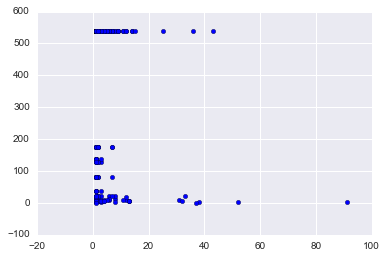

In [439]:
plt.scatter(cnt, size)

In [465]:
degrees = defaultdict(int)
with open('data_created/graphs/user-tag.txt', 'r') as fl:
    for line in fl.readlines():
        n1, n2 = line.split('\t')
        degrees[float(n1)] += 1
        degrees[float(n2)] += 1

In [481]:
cnt_degrees = [(v, degrees[tag2index_dict[k]]) for k, v in tag_cnts.items() if k in tag2index_dict]

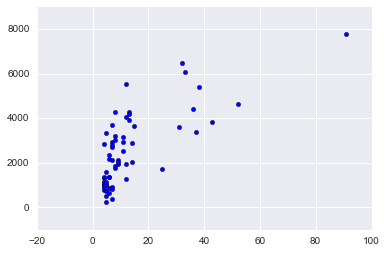

In [499]:
cnt_degrees_rel = filter(lambda x: x[0] > 3, cnt_degrees)
cnt, degree = zip(*cnt_degrees_rel)

plt.scatter(cnt, degree)

In [504]:
bad_q_acc_users = test_df.iloc[bad_questn]['AcceptedAnswerUserId'].values

In [509]:
good_q_acc_users = test_df.iloc[good_questn]['AcceptedAnswerUserId'].values

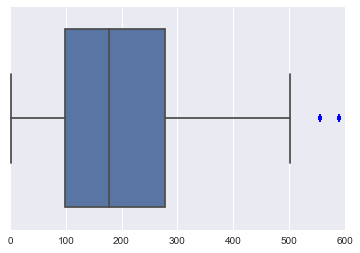

In [517]:
sns.boxplot(x=[degrees[u] for u in good_q_acc_users])

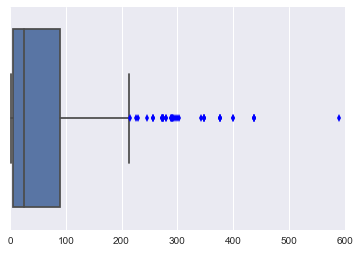

In [518]:
sns.boxplot(x=[degrees[u] for u in bad_q_acc_users])